In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
from scipy.spatial.distance import cdist
from numpy import random,matlib,linalg
from PIL import Image
#for Jupyter Notebook
%matplotlib inline 
class pycolor:
    RED = '\033[31m'
    END = '\033[0m'

# Dataset

In [2]:
Visual_category = loadmat('../data/visual_category.mat')
v_candidate = Visual_category['VGG19_candidate'].T
c_candidate = Visual_category['word2vec_candidate'].T
add_features = loadmat('../data/additional_visual&category.mat')
VGG19_ILSVRC = add_features['VGG19_ILSVRC'].T
word2vec_ILSVRC = add_features['word2vec_ILSVRC'].T
VGG19_ILSVRC_without = add_features['VGG19_ILSVRC_without'].T
word2vec_ILSVRC_without = add_features['word2vec_ILSVRC_without'].T
def dataset(subject):
    fMRI = loadmat('data/fMRI_data/subject0{}.mat'.format(subject))
    f_train = fMRI['sub0{}_train'.format(subject)].T
    f_test = fMRI['sub0{}_test_ave'.format(subject)].T
    if subject == 1 or subject == 2 or subject == 3:
        v_train = Visual_category['VGG19_train'].T
        c_train = Visual_category['word2vec_train'].T
    else:
        v_train = Visual_category['VGG19_train_sub0{}'.format(subject)].T
        c_train = Visual_category['word2vec_train_sub0{}'.format(subject)].T
    print('Voxels : {}'.format(f_train.shape[0]))
    return f_train,v_train,c_train,f_test

# Parameters

In [3]:
def parameter(f_train,v_train,c_train,f_test):
    N = f_train.shape[1]
    N_test = f_test.shape[1]
    D = [f_train.shape[0],v_train.shape[0],c_train.shape[0]]
    Dz = min(D[0],D[1],D[2])
    print('Dimensions of latent variables : {}'.format(Dz))
    return N,N_test,D,Dz

# Normalize

In [4]:
def normalize(f_train,v_train,c_train):
    N = np.size(f_train,1)
    X_mean = [np.mean(f_train,axis=1),np.mean(v_train,axis=1),np.mean(c_train,axis=1)]
    X_norm = [np.std(f_train,axis=1,ddof=1),np.std(v_train,axis=1,ddof=1),np.std(c_train,axis=1,ddof=1)]
    X_train = [f_train-matlib.repmat(X_mean[0],N,1).T,v_train-matlib.repmat(X_mean[1],N,1).T,c_train-matlib.repmat(X_mean[2],N,1).T]
    X = [X_train[0]/matlib.repmat(X_norm[0],N,1).T,X_train[1]/matlib.repmat(X_norm[1],N,1).T,X_train[2]/matlib.repmat(X_norm[2],N,1).T]
    return X,X_mean,X_norm
def normalize_item(item,X_mean,X_norm):
    N_item = np.size(item,1)
    item = item-matlib.repmat(X_mean,N_item,1).T
    item = item/matlib.repmat(X_norm,N_item,1).T
    return item
def renormalize_item(item,X_mean,X_norm):
    N_item = np.size(item,1)
    item = item*matlib.repmat(X_norm,N_item,1).T
    item = item+matlib.repmat(X_mean,N_item,1).T
    return item

# Hyper-parameters

In [5]:
subject = 3 # subject index
maxiter = 10 # number of updating model parameters
thres_a_inv = 1e-1 # ARD parameter
eta = 0.5 # trade-off parameter between visual features and category features
N_trial = 10 # trial numbers of model training and prediction (N_trial was set to 1000 in the original paper.)

# Initialize

In [6]:
def initialize(X,N,D,Dz):   
    # Z
    Z = random.randn(Dz,N)
    SigmaZ_inv = np.eye(Dz)
    SZZ = Z@Z.T + N*SigmaZ_inv
    SZZrep = [matlib.repmat(np.diag(SZZ),D[0],1),matlib.repmat(np.diag(SZZ),D[1],1),matlib.repmat(np.diag(SZZ),D[2],1)]
    # alpha,gamma
    A_inv = [np.ones((D[0],Dz)),np.ones((D[1],Dz)),np.ones((D[2],Dz))]
    A0_inv = [np.zeros((D[0],Dz)),np.zeros((D[1],Dz)),np.zeros((D[2],Dz))]
    gamma0 = [np.zeros((D[0],Dz)),np.zeros((D[1],Dz)),np.zeros((D[2],Dz))]
    gamma = [1/2+gamma0[0],1/2+gamma0[1],1/2+gamma0[2]]
    gamma_xx = [np.sum(X[0]**2)/2,np.sum(X[1]**2)/2,np.sum(X[2]**2)/2]
    gamma_beta = [D[0]*N/2,D[1]*N/2,D[2]*N/2]
    # beta
    beta_inv = [1,1,1]
    return Z,SZZrep,A_inv,A0_inv,gamma0,gamma,gamma_xx,gamma_beta,beta_inv

# Update

In [7]:
def update(X,N,Z,SZZrep,A_inv,A0_inv,gamma0,gamma,gamma_xx,gamma_beta,beta_inv,D):
    # initialize
    SigmaW_inv = [0]*3
    W = [0]*3
    WW = [0]*3
    beta_inv_gamma = [0]*3
    print ('********************subject={},trial={},iteration={}'.format(subject,t,maxiter))
    for l in range(maxiter):
        # W-step
        for i in range(3):
            SigmaW_inv[i] = A_inv[i]/((1/beta_inv[i])*SZZrep[i]*A_inv[i]+1)
            W[i] = (1/beta_inv[i])*X[i]@Z.T*SigmaW_inv[i]
            WW[i] = np.diag(SigmaW_inv[i].sum(axis=0))+W[i].T@W[i]
        # Z-step
        SigmaZ = (1/beta_inv[0])*WW[0]+(1/beta_inv[1])*WW[1]+(1/beta_inv[2])*WW[2]+np.eye(Dz)
        SigmaZ_inv = linalg.inv(SigmaZ)
        Z =  (1/beta_inv[0])*SigmaZ_inv@W[0].T@X[0]+(1/beta_inv[1])*SigmaZ_inv@W[1].T@X[1]+(1/beta_inv[2])*SigmaZ_inv@W[2].T@X[2]
        SZZ = Z@Z.T + N*SigmaZ_inv
        SZZrep = [matlib.repmat(np.diag(SZZ),D[0],1),matlib.repmat(np.diag(SZZ),D[1],1),matlib.repmat(np.diag(SZZ),D[2],1)]
        # missing obsevation
        X[0][:,tr_num:tr_num+N_add] = W[0]@Z[:,tr_num:tr_num+N_add]
        for i in range(3):
            # alpha-step
            A_inv[i] = (W[i]**2/2+SigmaW_inv[i]/2+gamma0[i]*A0_inv[i])/gamma[i]
            # beta-step
            beta_inv_gamma[i] = gamma_xx[i]-np.trace(W[i]@Z@X[i].T)+np.trace(SZZ@WW[i])/2
            beta_inv[i] = beta_inv_gamma[i]/gamma_beta[i]
        # find irrelevance parameters
        a_inv = [A_inv[0].sum(axis=0),A_inv[1].sum(axis=0),A_inv[2].sum(axis=0)]
        a_inv_max = [max(a_inv[0]),max(a_inv[1]),max(a_inv[2])]
        ix_a = [a_inv[0]>a_inv_max[0]*thres_a_inv, a_inv[1]>a_inv_max[1]*thres_a_inv, a_inv[2]>a_inv_max[2]*thres_a_inv]
        ix_z = np.logical_and(ix_a[0],ix_a[1],ix_a[2])
    print('Effect number of dimensions (ARD) : {}'.format(np.sum(ix_z)))
    print('Update N:',N,'tr_num:',tr_num,'N_add:',N_add)
    return W,WW,beta_inv,Z,X

# Predict

In [8]:
def predict(W,WW,beta_inv,f_test,D,Dz):
    # calculate posterior z from fMRI activity
    SigmaZnew = (1/beta_inv[0])*WW[0]+np.eye(Dz)
    SigmaZnew_inv = linalg.inv(SigmaZnew)
    prZ = SigmaZnew_inv@((1/beta_inv[0])*W[0].T@f_test)
    # predictive distribution
    v_pred = W[1]@prZ
    v_pred_cov = W[1]@SigmaZnew_inv@W[1].T+beta_inv[1]*np.eye(D[1])
    c_pred = W[2]@prZ
    c_pred_cov = W[2]@SigmaZnew_inv@W[2].T+beta_inv[2]*np.eye(D[2])
    return v_pred,c_pred

# Estimate image categories

In [9]:
def evaluate(V_pred,C_pred):
    # Estimate image categories from visual features
    v_corr = (1 - cdist(V_pred.T, v_candidate.T, metric='correlation'))
    # Estimate image categories from category features
    c_corr = (1 - cdist(C_pred.T, c_candidate.T, metric='correlation'))
    # Rankings of estimated image categories
    def calc_rank(corr):
        sort = np.sort(corr,axis=1)[:,::-1]
        sort_ix = np.argsort(corr,axis=1)[:,::-1]
        Rank = []
        for i in range(N_test):
            Rank.append(int(np.where(sort_ix[i,:]==i)[0]+1))
        return Rank,sort,sort_ix
    def calc_acc(corr):
        accuracy = []
        for i in range(np.size(corr,0)):
            correct = 0
            for j in range(np.size(corr,1)):
                if corr[i,i] > corr[i,j]:
                    correct += 1
            accuracy.append(correct/(np.size(corr,1)-1))
        return accuracy
    # fusion of estimated rankings
    corr_fusion = eta*v_corr+(1-eta)*c_corr
    Rank_fusion,candidate_corr,candidate_ix = calc_rank(corr_fusion)
    Acc_fusion = calc_acc(corr_fusion)
    test_Rank_fusion = np.mean(Rank_fusion)
    test_Acc_fusion = np.mean(Acc_fusion)
    print('Average ranks from fusion results : {}'.format(test_Rank_fusion))
    print('Average accuracy from fusion results : {}'.format(test_Acc_fusion))
    return Rank_fusion,candidate_ix,test_Rank_fusion,test_Acc_fusion

# Generate N-trial samples

In [10]:
V_pred = C_pred = 0
f_train,v_train,c_train,f_test = dataset(subject)
N,N_test,D,Dz = parameter(f_train,v_train,c_train,f_test)
# additional features
v_add = VGG19_ILSVRC # Semi-MVBGM
c_add = word2vec_ILSVRC # Semi-MVBGM
#v_add = VGG19_ILSVRC_without # Semi-MVBGM-w/o
#c_add = word2vec_ILSVRC_without # Semi-MVBGM-w/o
tr_num = N
N_add = np.size(v_add,axis=1)
# normalize
X,X_mean,X_norm = normalize(f_train,v_train,c_train)
X_add_v,X_add_c = normalize_item(v_add,X_mean[1],X_norm[1]),normalize_item(c_add,X_mean[2],X_norm[2])
f_prior = random.randn(D[0],N_add)
X_semi = [np.concatenate([X[0],f_prior],1),np.concatenate([X[1],X_add_v],1),np.concatenate([X[2],X_add_c],1)]
for t in range(N_trial):
    Z,SZZrep,A_inv,A0_inv,gamma0,gamma,gamma_xx,gamma_beta,beta_inv = initialize(X_semi,N+N_add,D,Dz)
    W,WW,beta_inv,Z,X_update = update(X_semi,N+N_add,Z,SZZrep,A_inv,A0_inv,gamma0,gamma,gamma_xx,gamma_beta,beta_inv,D)
    X_test = normalize_item(f_test,X_mean[0],X_norm[0])

    v_pred,c_pred = predict(W,WW,beta_inv,X_test,D,Dz)
    v_pred = renormalize_item(v_pred,X_mean[1],X_norm[1])
    c_pred = renormalize_item(c_pred,X_mean[2],X_norm[2])

    V_pred += v_pred
    C_pred += c_pred
    
# average of N-trials
V_pred_mean = V_pred/N_trial
C_pred_mean = C_pred/N_trial
print('****************************************Estimation Result')
Rank_fusion,candidate_ix,mean_rank,mean_acc = evaluate(V_pred_mean,C_pred_mean)

Voxels : 4643
Dimensions of latent variables : 300
********************subject=3,trial=0,iteration=10
Effect number of dimensions (ARD) : 210
Update N: 2200 tr_num: 1200 N_add: 1000
********************subject=3,trial=1,iteration=10
Effect number of dimensions (ARD) : 300
Update N: 2200 tr_num: 1200 N_add: 1000
********************subject=3,trial=2,iteration=10
Effect number of dimensions (ARD) : 294
Update N: 2200 tr_num: 1200 N_add: 1000
********************subject=3,trial=3,iteration=10
Effect number of dimensions (ARD) : 293
Update N: 2200 tr_num: 1200 N_add: 1000
********************subject=3,trial=4,iteration=10
Effect number of dimensions (ARD) : 287
Update N: 2200 tr_num: 1200 N_add: 1000
********************subject=3,trial=5,iteration=10
Effect number of dimensions (ARD) : 294
Update N: 2200 tr_num: 1200 N_add: 1000
********************subject=3,trial=6,iteration=10
Effect number of dimensions (ARD) : 273
Update N: 2200 tr_num: 1200 N_add: 1000
********************subject=3,tr

# Estimated image categories for each test image

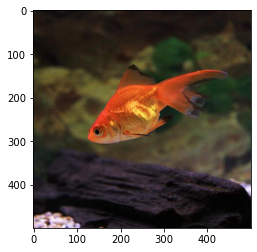

test image category : goldfish

Rank 1 : fire-bellied_toad

Rank 2 : chorus_frog

Rank 3 : grass_frog

Rank 4 : tarahumara_frog

Rank 5 : eastern_cricket_frog

   *
   *
   *
Rank 379 : goldfish



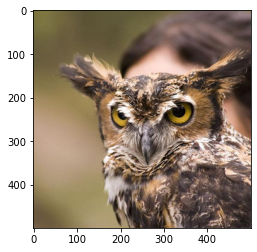

test image category : owl

Rank 1 : common_iguana

Rank 2 : galago

Rank 3 : monkey

Rank 4 : chimpanzee

Rank 5 : great_ape

   *
   *
   *
Rank 26 : owl



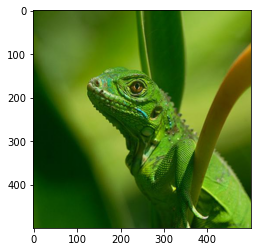

test image category : common_iguana

Rank 1 : cascades_frog

Rank 2 : fire-bellied_toad

Rank 3 : western_toad

Rank 4 : chorus_frog

Rank 5 : caiman_lizard

   *
   *
   *
Rank 20 : common_iguana



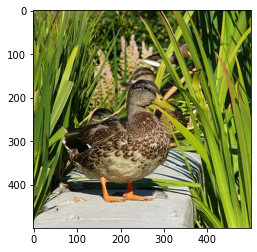

test image category : duck

Rank 1 : crapaud

Rank 2 : eastern_fence_lizard

Rank 3 : obstetrical_toad

Rank 4 : button_quail

Rank 5 : western_toad

   *
   *
   *
Rank 96 : duck



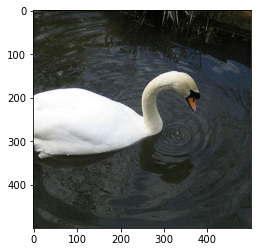

test image category : swan

Rank 1 : red-bellied_snake

Rank 2 : green_snake

Rank 3 : water_snake

Rank 4 : smooth_green_snake

Rank 5 : ringneck_snake

   *
   *
   *
Rank 101 : swan



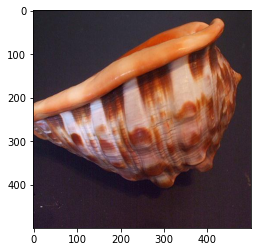

test image category : conch

Rank 1 : winter_melon

Rank 2 : net_melon

Rank 3 : gourd

Rank 4 : mussel

Rank 5 : gourd

   *
   *
   *
Rank 206 : conch



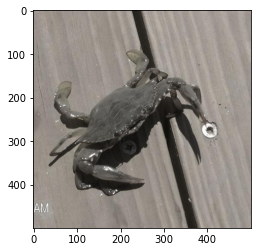

test image category : crab

Rank 1 : dung_beetle

Rank 2 : mud_turtle

Rank 3 : canyon_treefrog

Rank 4 : smooth_softshell

Rank 5 : crapaud

   *
   *
   *
Rank 393 : crab



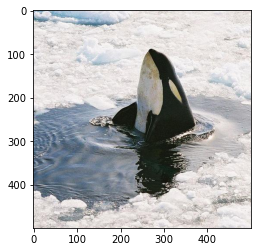

test image category : killer_whale

Rank 1 : aquatic_bird

Rank 2 : pelican

Rank 3 : mallard

Rank 4 : earless_lizard

Rank 5 : great_white_heron

   *
   *
   *
Rank 376 : killer_whale



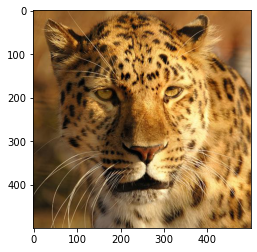

test image category : leopard

Rank 1 : western_grey_squirrel

Rank 2 : flickertail

Rank 3 : mantled_ground_squirrel

Rank 4 : eastern_grey_squirrel

Rank 5 : obstetrical_toad

   *
   *
   *
Rank 292 : leopard



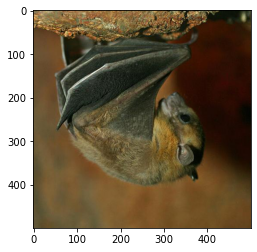

test image category : bat

Rank 1 : fire-bellied_toad

Rank 2 : chorus_frog

Rank 3 : cascades_frog

Rank 4 : tarahumara_frog

Rank 5 : northern_cricket_frog

   *
   *
   *
Rank 178 : bat



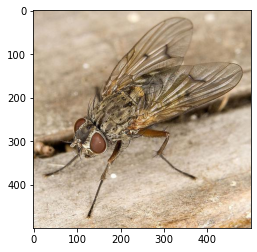

test image category : housefly

Rank 1 : water_boatman

Rank 2 : vespid

Rank 3 : mantispid

Rank 4 : paper_wasp

Rank 5 : bird_louse

   *
   *
   *
Rank 47 : housefly



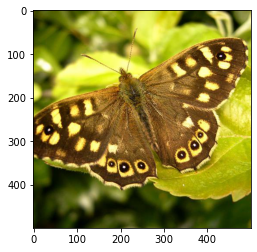

test image category : butterfly

Rank 1 : social_insect

Rank 2 : scorpion

Rank 3 : paper_wasp

Rank 4 : eastern_fence_lizard

Rank 5 : sand_lizard

   *
   *
   *
Rank 314 : butterfly



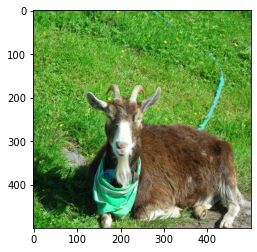

test image category : goat

Rank 1 : monkey

Rank 2 : tree_squirrel

Rank 3 : rock_squirrel

Rank 4 : eurasian_otter

Rank 5 : squirrel

   *
   *
   *
Rank 132 : goat



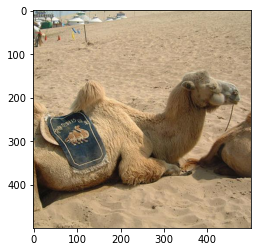

test image category : camel

Rank 1 : gavial

Rank 2 : marine_iguana

Rank 3 : night_lizard

Rank 4 : fringe-toed_lizard

Rank 5 : earless_lizard

   *
   *
   *
Rank 1050 : camel



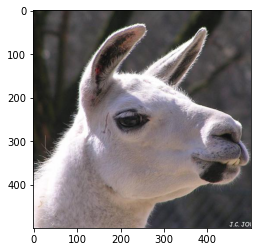

test image category : domestic_llama

Rank 1 : rabbit

Rank 2 : goat

Rank 3 : mammal

Rank 4 : dog

Rank 5 : european_rabbit

   *
   *
   *
Rank 49 : domestic_llama



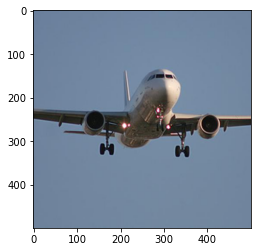

test image category : airliner

Rank 1 : sport_kite

Rank 2 : hang_glider

Rank 3 : multiengine_airplane

Rank 4 : swallow-tailed_kite

Rank 5 : amphibian

   *
   *
   *
Rank 157 : airliner



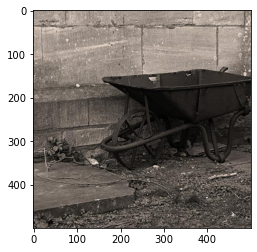

test image category : barrow

Rank 1 : hand_mower

Rank 2 : waterwheel

Rank 3 : allen_wrench

Rank 4 : lathe

Rank 5 : trencher

   *
   *
   *
Rank 280 : barrow



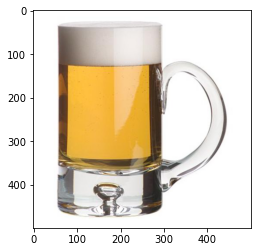

test image category : beer_mug

Rank 1 : aspirator

Rank 2 : parabolic_reflector

Rank 3 : fire_extinguisher

Rank 4 : stud_finder

Rank 5 : eggbeater

   *
   *
   *
Rank 350 : beer_mug



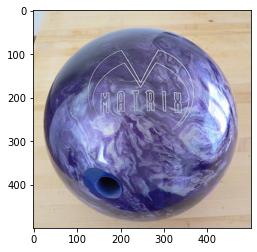

test image category : bowling_ball

Rank 1 : stud_finder

Rank 2 : knob

Rank 3 : canister

Rank 4 : audio_cd

Rank 5 : sleigh_bell

   *
   *
   *
Rank 516 : bowling_ball



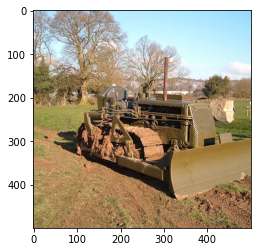

test image category : bulldozer

Rank 1 : trencher

Rank 2 : fly_rod

Rank 3 : hand_mower

Rank 4 : birchbark_canoe

Rank 5 : canoe

   *
   *
   *
Rank 115 : bulldozer



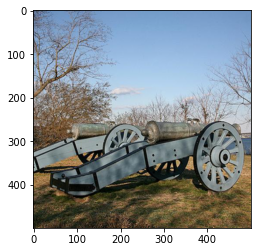

test image category : cannon

Rank 1 : harpoon_gun

Rank 2 : rotor

Rank 3 : single_prop

Rank 4 : windmill

Rank 5 : hand_mower

   *
   *
   *
Rank 15 : cannon



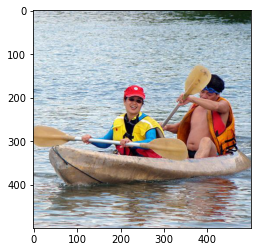

test image category : canoe

Rank 1 : canoe

Rank 2 : polo_mallet

Rank 3 : bb_gun

Rank 4 : racing_boat

Rank 5 : jabiru



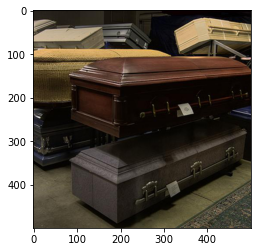

test image category : coffin

Rank 1 : typewriter

Rank 2 : lathe

Rank 3 : electric_range

Rank 4 : tape_recorder

Rank 5 : cassette_deck

   *
   *
   *
Rank 267 : coffin



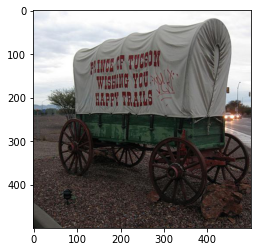

test image category : covered_wagon

Rank 1 : bicycle

Rank 2 : bicycle-built-for-two

Rank 3 : trencher

Rank 4 : wagon

Rank 5 : tractor

   *
   *
   *
Rank 16 : covered_wagon



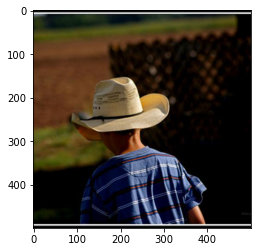

test image category : cowboy_hat

Rank 1 : kite_balloon

Rank 2 : balloon

Rank 3 : eggbeater

Rank 4 : sleigh_bell

Rank 5 : archilochus_colubris

   *
   *
   *
Rank 530 : cowboy_hat



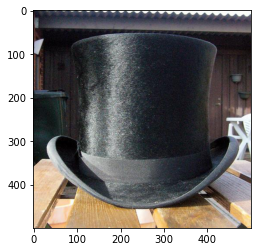

test image category : dress_hat

Rank 1 : knob

Rank 2 : dishpan

Rank 3 : loofa

Rank 4 : monkey-wrench

Rank 5 : darning_needle

   *
   *
   *
Rank 521 : dress_hat



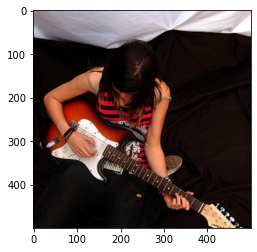

test image category : electric_guitar

Rank 1 : polo_mallet

Rank 2 : eggbeater

Rank 3 : shoulder_holster

Rank 4 : camera_tripod

Rank 5 : rollerblade

   *
   *
   *
Rank 267 : electric_guitar



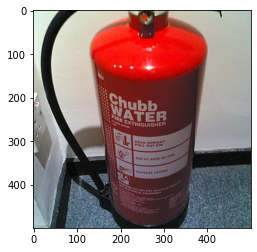

test image category : fire_extinguisher

Rank 1 : device

Rank 2 : paper_feed

Rank 3 : optical_device

Rank 4 : pencil_sharpener

Rank 5 : kicksorter

   *
   *
   *
Rank 13 : fire_extinguisher



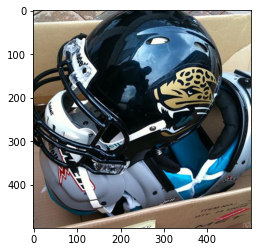

test image category : football_helmet

Rank 1 : steering_wheel

Rank 2 : sweet_melon

Rank 3 : thumbtack

Rank 4 : electric_refrigerator

Rank 5 : allen_wrench

   *
   *
   *
Rank 463 : football_helmet



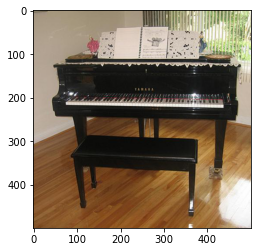

test image category : grand_piano

Rank 1 : electric_range

Rank 2 : cassette_deck

Rank 3 : addressing_machine

Rank 4 : ghetto_blaster

Rank 5 : epidiascope

   *
   *
   *
Rank 127 : grand_piano



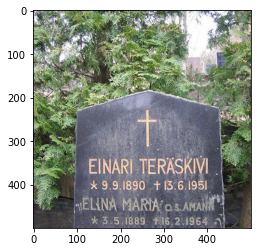

test image category : gravestone

Rank 1 : gnomon

Rank 2 : allen_wrench

Rank 3 : fahrenheit_thermometer

Rank 4 : source_of_illumination

Rank 5 : device

   *
   *
   *
Rank 10 : gravestone



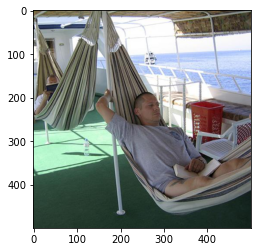

test image category : hammock

Rank 1 : unicyclist

Rank 2 : rollerblading

Rank 3 : handcar

Rank 4 : tricycle

Rank 5 : luging

   *
   *
   *
Rank 39 : hammock



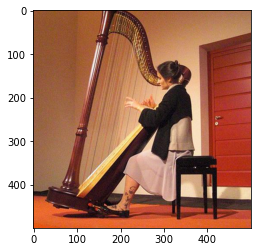

test image category : harp

Rank 1 : camera_tripod

Rank 2 : sword

Rank 3 : bow_and_arrow

Rank 4 : bb_gun

Rank 5 : polo_mallet

   *
   *
   *
Rank 775 : harp



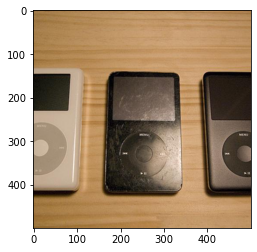

test image category : ipod

Rank 1 : dishpan

Rank 2 : knob

Rank 3 : whiskey_jug

Rank 4 : jampot

Rank 5 : canister

   *
   *
   *
Rank 175 : ipod



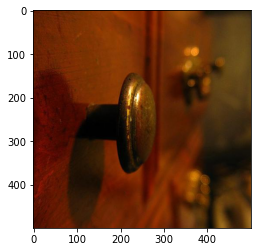

test image category : knob

Rank 1 : darning_needle

Rank 2 : clothespin

Rank 3 : oilcan

Rank 4 : eggbeater

Rank 5 : electromagnet

   *
   *
   *
Rank 7 : knob



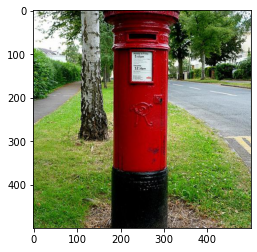

test image category : mailbox

Rank 1 : trencher

Rank 2 : easel

Rank 3 : fire_extinguisher

Rank 4 : transmitter

Rank 5 : oilcan

   *
   *
   *
Rank 17 : mailbox



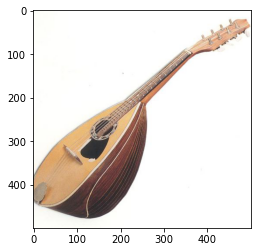

test image category : mandolin

Rank 1 : eggbeater

Rank 2 : knife

Rank 3 : screw_wrench

Rank 4 : letter_opener

Rank 5 : knob

   *
   *
   *
Rank 364 : mandolin



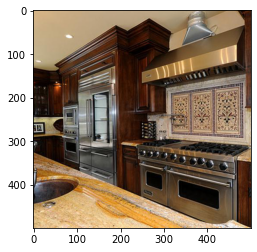

test image category : microwave

Rank 1 : cassette_deck

Rank 2 : forklift

Rank 3 : machine_tool

Rank 4 : electric_range

Rank 5 : table_saw

   *
   *
   *
Rank 112 : microwave



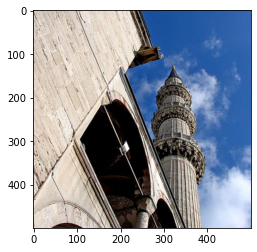

test image category : minaret

Rank 1 : overhead_projector

Rank 2 : textile_machine

Rank 3 : camera_tripod

Rank 4 : footstool

Rank 5 : transmitter

   *
   *
   *
Rank 1067 : minaret



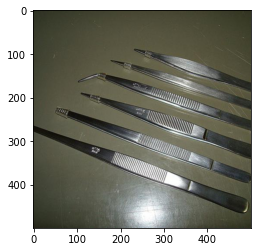

test image category : pincer

Rank 1 : knife

Rank 2 : allen_wrench

Rank 3 : screw_wrench

Rank 4 : letter_opener

Rank 5 : darning_needle

   *
   *
   *
Rank 54 : pincer



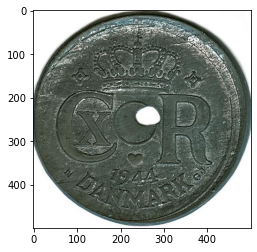

test image category : planchet

Rank 1 : steering_wheel

Rank 2 : knob

Rank 3 : audio_cd

Rank 4 : wristwatch

Rank 5 : cd-r

   *
   *
   *
Rank 44 : planchet



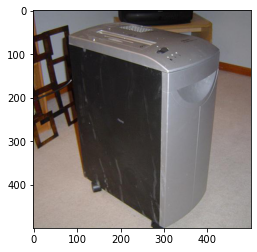

test image category : shredder

Rank 1 : paper_feed

Rank 2 : flash_camera

Rank 3 : epidiascope

Rank 4 : acoustic_modem

Rank 5 : laptop

   *
   *
   *
Rank 26 : shredder



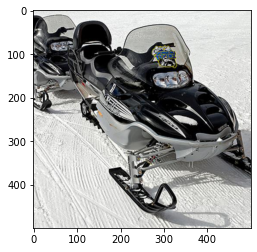

test image category : snowmobile

Rank 1 : power_mower

Rank 2 : hand_mower

Rank 3 : screw_wrench

Rank 4 : winch

Rank 5 : tie_rod

   *
   *
   *
Rank 171 : snowmobile



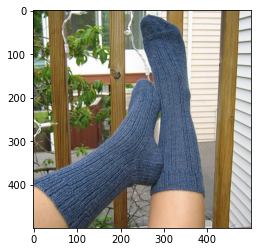

test image category : sock

Rank 1 : australian_blacksnake

Rank 2 : eastern_fence_lizard

Rank 3 : bushbuck

Rank 4 : red-bellied_snake

Rank 5 : night_lizard

   *
   *
   *
Rank 723 : sock



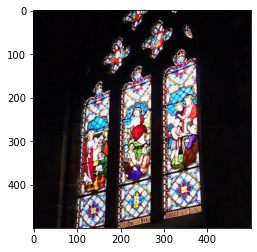

test image category : stained-glass_window

Rank 1 : vending_machine

Rank 2 : kite_balloon

Rank 3 : stemma

Rank 4 : fire_extinguisher

Rank 5 : blimp

   *
   *
   *
Rank 107 : stained-glass_window



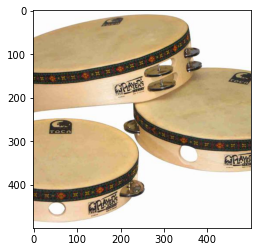

test image category : tambourine

Rank 1 : device

Rank 2 : socket_wrench

Rank 3 : electronic_device

Rank 4 : memory_device

Rank 5 : optical_device

   *
   *
   *
Rank 386 : tambourine



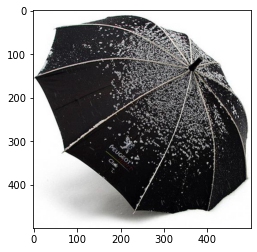

test image category : umbrella

Rank 1 : snake

Rank 2 : social_insect

Rank 3 : water_snake

Rank 4 : giant_water_bug

Rank 5 : smooth_softshell

   *
   *
   *
Rank 6102 : umbrella



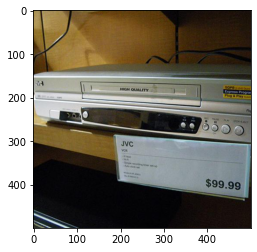

test image category : videocassette_recorder

Rank 1 : cassette_deck

Rank 2 : device

Rank 3 : laptop

Rank 4 : paper_feed

Rank 5 : keyboard

   *
   *
   *
Rank 28 : videocassette_recorder



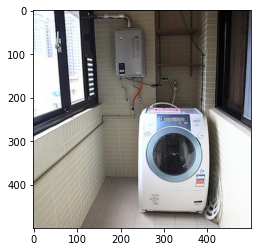

test image category : washer

Rank 1 : textile_machine

Rank 2 : machine_tool

Rank 3 : table_saw

Rank 4 : electric_range

Rank 5 : epidiascope

   *
   *
   *
Rank 37 : washer



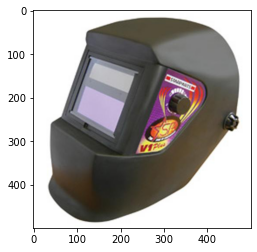

test image category : welder's_mask

Rank 1 : stud_finder

Rank 2 : flash_camera

Rank 3 : paper_feed

Rank 4 : pencil_sharpener

Rank 5 : fire_extinguisher

   *
   *
   *
Rank 27 : welder's_mask



In [11]:
for test_index in range(1,51):
    # read image
    im = Image.open('../data/test_images/test{}.JPEG'.format(test_index))
    plt.imshow(im)
    plt.show()
    # read canididate
    f = open('../data/candidate_name.txt')
    candidate = f.readlines()
    print('test image category : {}'.format(candidate[test_index-1]))
    flag = 0
    for i in range(5):
        if i ==  Rank_fusion[test_index-1]-1:
            print(pycolor.RED + 'Rank {} : {}'.format(i+1,candidate[candidate_ix[test_index-1,i]]) + pycolor.END)
            flag = 1
        else:
            print('Rank {} : {}'.format(i+1,candidate[candidate_ix[test_index-1,i]]))
    if flag == 0:
        print('   *\n   *\n   *')
        print(pycolor.RED + 'Rank {} : {}'.format(Rank_fusion[test_index-1],candidate[test_index-1]) + pycolor.END)